2024-08-16 09:18:36,570 - INFO - Successfully read the file
2024-08-16 09:18:39,311 - INFO - Epoch 1/200, Loss: 0.0186
2024-08-16 09:18:39,509 - INFO - Epoch 2/200, Loss: 0.0082
2024-08-16 09:18:39,730 - INFO - Epoch 3/200, Loss: 0.0042
2024-08-16 09:18:39,943 - INFO - Epoch 4/200, Loss: 0.0040
2024-08-16 09:18:40,158 - INFO - Epoch 5/200, Loss: 0.0037
2024-08-16 09:18:40,350 - INFO - Epoch 6/200, Loss: 0.0039
2024-08-16 09:18:40,568 - INFO - Epoch 7/200, Loss: 0.0036
2024-08-16 09:18:40,819 - INFO - Epoch 8/200, Loss: 0.0037
2024-08-16 09:18:41,055 - INFO - Epoch 9/200, Loss: 0.0034
2024-08-16 09:18:41,226 - INFO - Epoch 10/200, Loss: 0.0032
2024-08-16 09:18:41,406 - INFO - Epoch 11/200, Loss: 0.0031
2024-08-16 09:18:41,600 - INFO - Epoch 12/200, Loss: 0.0028
2024-08-16 09:18:41,780 - INFO - Epoch 13/200, Loss: 0.0028
2024-08-16 09:18:41,941 - INFO - Epoch 14/200, Loss: 0.0026
2024-08-16 09:18:42,099 - INFO - Epoch 15/200, Loss: 0.0025
2024-08-16 09:18:42,249 - INFO - Epoch 16/200, Lo

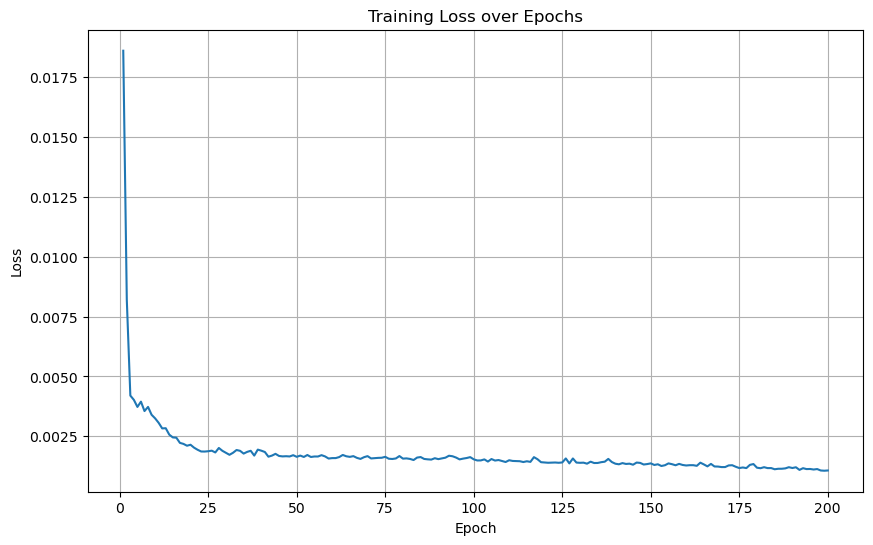

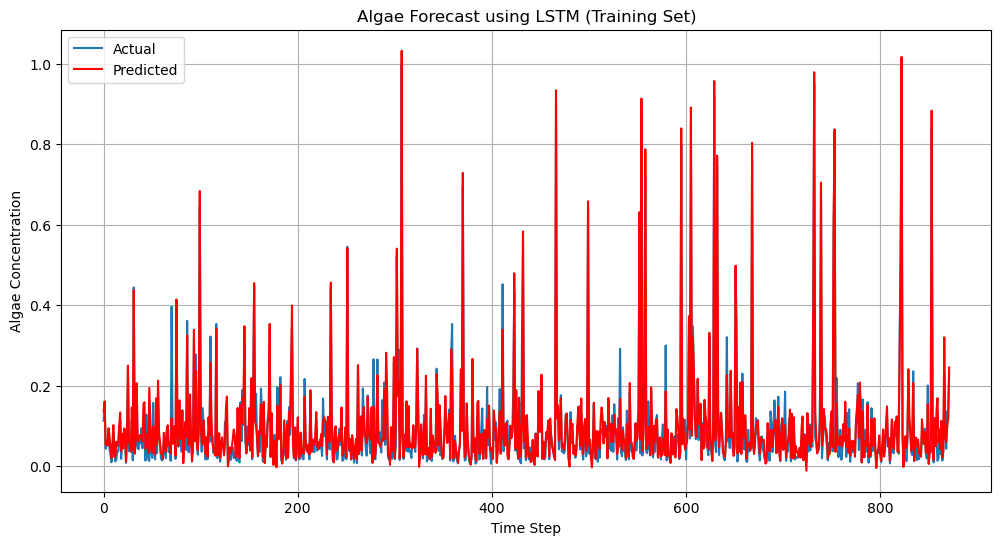

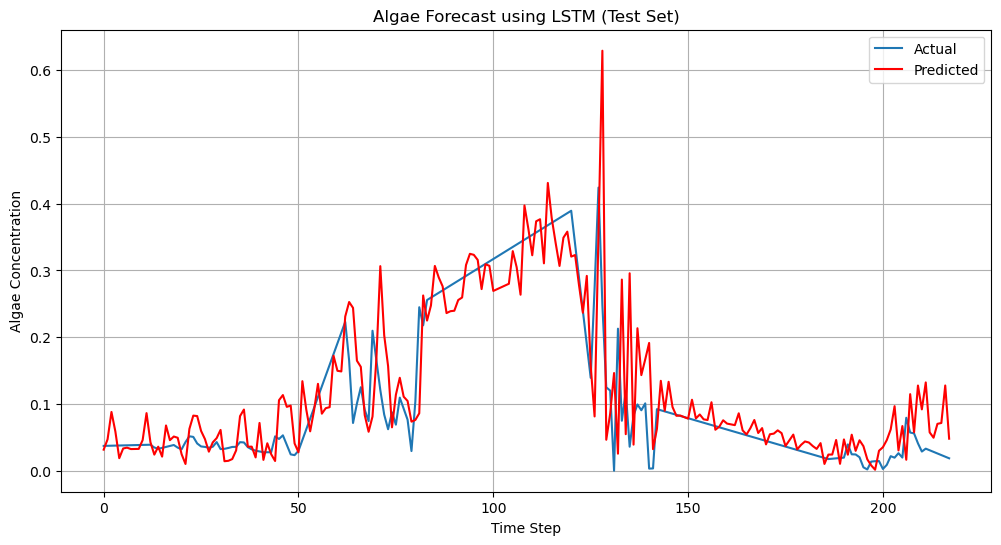

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def preprocess_data(df, sequence_length):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.ffill()

    # Create binary feature for weather being '晴'
    df['is_sunny'] = df['weather'].apply(lambda x: '晴' in x).astype(int)

    # Convert wind_power to numerical feature indicating if wind_power is greater than 4
    df['wind_power'] = df['wind_power'].str.extract(r'(\d+)级').astype(int)
    df['high_wind_power'] = (df['wind_power'] > 4).astype(int)

    features = ['temp', 'oxygen', 'NH3', 'TP', 'TN', 'algae', 'is_sunny', 'high_wind_power']
    df_features = df[features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df.index)

    # Create sequences
    data = []
    for i in range(len(df_scaled) - sequence_length):
        data.append(df_scaled.iloc[i:i+sequence_length].values)
    data = np.array(data)

    # Split into inputs and targets
    X = data[:, :-1, :]
    y = data[:, -1, features.index('algae')]

    return X, y, scaler

def create_dataloaders(X, y, batch_size, train_size=0.8):
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    losses = []  # 用于存储每个epoch的loss
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        logging.info(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    return losses


def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def evaluate_lstm_model(model, loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in loader:
            output = model(inputs)
            predictions.append(output.squeeze().numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(targets, label='Actual')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Algae Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/AlgaeBloomForecast/merged_data.csv', encoding='utf-8')
        logging.info("Successfully read the file")

        sequence_length = 5  # Number of previous time steps to consider for prediction
        X, y, scaler = preprocess_data(df, sequence_length)

        batch_size = 16
        train_loader, test_loader = create_dataloaders(X, y, batch_size)

        input_size = X.shape[2]  # Number of features
        hidden_size = 64
        num_layers = 2
        output_size = 1


        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        epochs = 200

        losses = train_lstm_model(model, train_loader, criterion, optimizer, epochs)
        
        # Plot the loss
        plot_loss(losses)

        # ... (previous code remains unchanged)

        train_predictions, train_targets = evaluate_lstm_model(model, train_loader)
        test_predictions, test_targets = evaluate_lstm_model(model, test_loader)

        # 创建一个全零的数组，其形状与原始归一化数据相同
        # 假设原始数据有8个特征，您只对其中的1个特征（algae）进行了预测
        num_features = X.shape[2]  # 假设 X 是您的原始输入数据
        full_train_predictions = np.zeros((len(train_predictions), num_features))
        full_test_predictions = np.zeros((len(test_predictions), num_features))
        full_train_targets = np.zeros((len(train_targets), num_features))
        full_test_targets = np.zeros((len(test_targets), num_features))

        # 假设algae是最后一个特征
        # 将预测和目标值放入相应的位置
        full_train_predictions[:, -1] = train_predictions
        full_test_predictions[:, -1] = test_predictions
        full_train_targets[:, -1] = train_targets
        full_test_targets[:, -1] = test_targets

        # 使用完整的特征集进行逆变换
        inverse_train_predictions = scaler.inverse_transform(full_train_predictions)[:, -1]
        inverse_test_predictions = scaler.inverse_transform(full_test_predictions)[:, -1]
        inverse_train_targets = scaler.inverse_transform(full_train_targets)[:, -1]
        inverse_test_targets = scaler.inverse_transform(full_test_targets)[:, -1]

        # Plot the forecast for training and test sets
        plot_forecast(inverse_train_targets, inverse_train_predictions, title='Algae Forecast using LSTM (Training Set)')
        plot_forecast(inverse_test_targets, inverse_test_predictions, title='Algae Forecast using LSTM (Test Set)')

    
    except Exception as e:
        logging.error(f"An error occurred in main: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()